In [2]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [4]:
# import system_message.txt as a string
with open('prompts/system_message.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze earnings call transcripts of companies and extract specific textual features, sentiment scores, and key financial metrics. These features will be used to predict the recovery rate of bonds issued by these companies.

Objective:
Given the provided earnings call transcript, extract the following features, metrics, and scores, and format the final output exactly as specified below.

1. Sentiment Scores:
Evaluate the sentiment expressed throughout the earnings call using the following categories:

Negative Sentiment (0-1): Measures the extent of negative language (e.g., risks, losses, challenges). A score closer to 1 indicates a highly negative tone.
Positive Sentiment (0-1): Assesses the presence of positive language (e.g., growth, profits, opportunities). A higher score indicates optimism.
Uncertainty Sentiment (0-1): Captures language related to uncertainty (e.g., "uncertain," 

In [5]:
transcripts = pd.read_csv('transcripts/mapped_transcripts.csv', delimiter='|')

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(transcripts['Cleaned_Bankruptcy_Indicators'].nunique())

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['Cleaned_Bankruptcy_Indicators'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'Cleaned_Bankruptcy_Indicators']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

196


,transcript_number,Cleaned_Bankruptcy_Indicators
0,0,oper instruct would now like to turn the call ...
1,1,as remind this confer is be record today tuesd...
2,2,present oper greet ladi and gentlemen and welc...
3,3,with me today are dick bond our presid and ceo...
4,4,present oper thank you for join the silgan hol...


In [6]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

output = []

for i in number_transcript['Cleaned_Bankruptcy_Indicators']:
    while True:
        try:
            completion = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": i}
                ]
            )
            output.append(completion.choices[0].message.content)
            break  # Exit the loop if the request was successful
        except:
            print("Rate limit exceeded, waiting for a minute...")
            time.sleep(60)  # Wait for a minute before retrying

Rate limit exceeded, waiting for a minute...


In [130]:
output_df = pd.DataFrame(columns=['negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
                                  'profitability', 'liquidity', 'leverage', 'operating', 'market', 'management',
                                  'sentiment', 'tone', 'forwardlooking', 'confidence',
                                  'icr', 'de', 'fcf', 'debt2ebitda', 'zscore'])

# split output into columns with regex and convert to float
output_df['negative'] = [float(i.split('; ')[0]) for i in output]
output_df['positive'] = [float(i.split('; ')[1]) for i in output]
output_df['uncertainty'] = [float(i.split('; ')[2]) for i in output]
output_df['litigious'] = [float(i.split('; ')[3]) for i in output]
output_df['strong'] = [float(i.split('; ')[4]) for i in output]
output_df['weak'] = [float(i.split('; ')[5]) for i in output]
output_df['profitability'] = [float(i.split('; ')[6]) for i in output]
output_df['liquidity'] = [float(i.split('; ')[7]) for i in output]
output_df['leverage'] = [float(i.split('; ')[8]) for i in output]
output_df['operating'] = [float(i.split('; ')[9]) for i in output]
output_df['market'] = [float(i.split('; ')[10]) for i in output]
output_df['management'] = [float(i.split('; ')[11]) for i in output]
output_df['sentiment'] = [float(i.split('; ')[12]) for i in output]
output_df['tone'] = [float(i.split('; ')[13]) for i in output]
output_df['forwardlooking'] = [float(i.split('; ')[14]) for i in output]
output_df['confidence'] = [float(i.split('; ')[15]) for i in output]
output_df['icr'] = [float(i.split('; ')[16]) for i in output]
output_df['de'] = [float(i.split('; ')[17]) for i in output]
output_df['fcf'] = [float(i.split('; ')[18]) for i in output]
output_df['debt2ebitda'] = [float(i.split('; ')[19]) for i in output]
output_df['zscore'] = [float(i.split('; ')[20]) for i in output]

output_df

,negative,positive,uncertainty,litigious,strong,weak,profitability,liquidity,leverage,operating,...,management,sentiment,tone,forwardlooking,confidence,icr,de,fcf,debt2ebitda,zscore
0,0.65,0.55,0.30,0.15,0.80,0.40,0.50,0.65,0.75,0.20,...,0.50,0.55,0.70,0.65,0.75,0.80,4.0,1.0,0.0,3.0
1,0.40,0.55,0.30,0.10,0.70,0.45,0.80,0.60,0.40,0.20,...,0.50,0.60,0.65,0.70,0.80,0.90,3.0,2.0,1.0,4.0
2,0.35,0.60,0.25,0.10,0.75,0.20,0.65,0.80,0.55,0.15,...,0.45,0.60,0.60,0.50,0.75,0.80,3.5,2.0,0.0,4.0
3,0.45,0.60,0.75,0.10,0.65,0.40,0.70,0.50,0.80,0.30,...,0.60,0.85,0.70,0.65,0.60,0.75,4.0,2.0,1.0,3.0
4,0.45,0.30,0.55,0.10,0.60,0.80,0.50,0.70,0.40,0.20,...,0.65,0.60,0.55,0.65,0.80,0.70,3.0,2.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.85,0.15,0.65,0.05,0.80,0.20,0.20,0.45,0.20,0.15,...,0.60,0.50,0.85,0.55,0.70,0.60,1.0,2.0,2.0,3.0
75,0.50,0.40,0.35,0.10,0.55,0.45,0.70,0.65,0.50,0.40,...,0.75,0.80,0.55,0.65,0.70,0.75,3.0,2.0,1.0,4.0
76,0.40,0.60,0.25,0.05,0.80,0.20,0.50,0.90,0.55,0.15,...,0.40,0.60,0.75,0.65,0.80,0.85,3.0,2.0,0.0,4.0
77,0.60,0.40,0.30,0.10,0.70,0.50,0.20,0.55,0.45,0.60,...,0.75,0.50,0.70,0.60,0.80,0.85,3.0,2.0,1.0,4.0


In [132]:
# merge output_df with transcripts on 'transcript_number'
transcripts = pd.merge(transcripts,
                          output_df,
                          on='transcript_number',
                          how='left')

# drop all rows where 'negative' is NaN
transcripts = transcripts.dropna(subset=['negative'])

174

In [134]:
# List of selected supporting features
supporting_features = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    #'3 month commercial paper minus federal funds rate',
    'Communication Services',  # Sector performance
    'Consumer Discretionary',  # Sector performance
    'Industrials',  # Sector performance
    'Senior secured',  # Seniority
    #'Time to maturity',  # Bond characteristic
    'Equity value',
    'CDS availability',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

llm_labels = ['negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
                'profitability', 'liquidity', 'leverage', 'operating', 'market', 'management',
                'sentiment', 'tone', 'forwardlooking', 'confidence',
                'icr', 'de', 'fcf', 'debt2ebitda', 'zscore']


# Select the supporting features, nlp_lables, and RR from final_df
final_df = transcripts[['Date'] + supporting_features + llm_labels + ['RR']]

final_df.head()

In [143]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     38.46
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          2.68e-158
Time:                        09:10:33   Log-Likelihood:                -3683.3
No. Observations:                 903   AIC:                             7445.
Df Residuals:                     864   BIC:                             7632.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

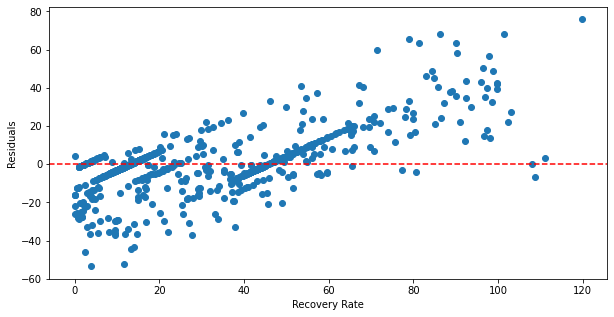

In [135]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()